The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==1.0.0
!pip install -U mxnet-cu112==1.9.1


# Adagrad
:label:`sec_adagrad`

Let's begin by considering learning problems with features that occur infrequently.


## Sparse Features and Learning Rates

Imagine that we are training a language model. To get good accuracy we typically want to decrease the learning rate as we keep on training, usually at a rate of $\mathcal{O}(t^{-\frac{1}{2}})$ or slower. Now consider a model training on sparse features, i.e., features that occur only infrequently. This is common for natural language, e.g., it is a lot less likely that we will see the word *preconditioning* than *learning*. However, it is also common in other areas such as computational advertising and personalized collaborative filtering. After all, there are many things that are of interest only for a small number of people.

Parameters associated with infrequent features only receive meaningful updates whenever these features occur. Given a decreasing learning rate we might end up in a situation where the parameters for common features converge rather quickly to their optimal values, whereas for infrequent features we are still short of observing them sufficiently frequently before their optimal values can be determined. In other words, the learning rate either decreases too slowly for frequent features or too quickly for infrequent ones.

A possible hack to redress this issue would be to count the number of times we see a particular feature and to use this as a clock for adjusting learning rates. That is, rather than choosing a learning rate of the form $\eta = \frac{\eta_0}{\sqrt{t + c}}$ we could use $\eta_i = \frac{\eta_0}{\sqrt{s(i, t) + c}}$. Here $s(i, t)$ counts the number of nonzeros for feature $i$ that we have observed up to time $t$. This is actually quite easy to implement at no meaningful overhead. However, it fails whenever we do not quite have sparsity but rather just data where the gradients are often very small and only rarely large. After all, it is unclear where one would draw the line between something that qualifies as an observed feature or not.

Adagrad by :citet:`Duchi.Hazan.Singer.2011` addresses this by replacing the rather crude counter $s(i, t)$ by an aggregate of the squares of previously observed gradients. In particular, it uses $s(i, t+1) = s(i, t) + \left(\partial_i f(\mathbf{x})\right)^2$ as a means to adjust the learning rate. This has two benefits: first, we no longer need to decide just when a gradient is large enough. Second, it scales automatically with the magnitude of the gradients. Coordinates that routinely correspond to large gradients are scaled down significantly, whereas others with small gradients receive a much more gentle treatment. In practice this leads to a very effective optimization procedure for computational advertising and related problems. But this hides some of the additional benefits inherent in Adagrad that are best understood in the context of preconditioning.


## Preconditioning

Convex optimization problems are good for analyzing the characteristics of algorithms. After all, for most nonconvex problems it is difficult to derive meaningful theoretical guarantees, but *intuition* and *insight* often carry over.  Let's look at the problem of minimizing $f(\mathbf{x}) = \frac{1}{2} \mathbf{x}^\top \mathbf{Q} \mathbf{x} + \mathbf{c}^\top \mathbf{x} + b$.

As we saw in :numref:`sec_momentum`, it is possible to rewrite this problem in terms of its eigendecomposition $\mathbf{Q} = \mathbf{U}^\top \boldsymbol{\Lambda} \mathbf{U}$ to arrive at a much simplified problem where each coordinate can be solved individually:

$$f(\mathbf{x}) = \bar{f}(\bar{\mathbf{x}}) = \frac{1}{2} \bar{\mathbf{x}}^\top \boldsymbol{\Lambda} \bar{\mathbf{x}} + \bar{\mathbf{c}}^\top \bar{\mathbf{x}} + b.$$

Here we used $\bar{\mathbf{x}} = \mathbf{U} \mathbf{x}$ and consequently $\bar{\mathbf{c}} = \mathbf{U} \mathbf{c}$. The modified problem has as its minimizer $\bar{\mathbf{x}} = -\boldsymbol{\Lambda}^{-1} \bar{\mathbf{c}}$ and minimum value $-\frac{1}{2} \bar{\mathbf{c}}^\top \boldsymbol{\Lambda}^{-1} \bar{\mathbf{c}} + b$. This is much easier to compute since $\boldsymbol{\Lambda}$ is a diagonal matrix containing the eigenvalues of $\mathbf{Q}$.

If we perturb $\mathbf{c}$ slightly we would hope to find only slight changes in the minimizer of $f$. Unfortunately this is not the case. While slight changes in $\mathbf{c}$ lead to equally slight changes in $\bar{\mathbf{c}}$, this is not the case for the minimizer of $f$ (and of $\bar{f}$ respectively). Whenever the eigenvalues $\boldsymbol{\Lambda}_i$ are large we will see only small changes in $\bar{x}_i$ and in the minimum of $\bar{f}$. Conversely, for small $\boldsymbol{\Lambda}_i$ changes in $\bar{x}_i$ can be dramatic. The ratio between the largest and the smallest eigenvalue is called the condition number of an optimization problem.

$$\kappa = \frac{\boldsymbol{\Lambda}_1}{\boldsymbol{\Lambda}_d}.$$

If the condition number $\kappa$ is large, it is difficult to solve the optimization problem accurately. We need to ensure that we are careful in getting a large dynamic range of values right. Our analysis leads to an obvious, albeit somewhat naive question: couldn't we simply "fix" the problem by distorting the space such that all eigenvalues are $1$. In theory this is quite easy: we only need the eigenvalues and eigenvectors of $\mathbf{Q}$ to rescale the problem from $\mathbf{x}$ to one in $\mathbf{z} \stackrel{\textrm{def}}{=} \boldsymbol{\Lambda}^{\frac{1}{2}} \mathbf{U} \mathbf{x}$. In the new coordinate system $\mathbf{x}^\top \mathbf{Q} \mathbf{x}$ could be simplified to $\|\mathbf{z}\|^2$. Alas, this is a rather impractical suggestion. Computing eigenvalues and eigenvectors is in general *much more* expensive than solving the actual  problem.

While computing eigenvalues exactly might be expensive, guessing them and computing them even somewhat approximately may already be a lot better than not doing anything at all. In particular, we could use the diagonal entries of $\mathbf{Q}$ and rescale it accordingly. This is *much* cheaper than computing eigenvalues.

$$\tilde{\mathbf{Q}} = \textrm{diag}^{-\frac{1}{2}}(\mathbf{Q}) \mathbf{Q} \textrm{diag}^{-\frac{1}{2}}(\mathbf{Q}).$$

In this case we have $\tilde{\mathbf{Q}}_{ij} = \mathbf{Q}_{ij} / \sqrt{\mathbf{Q}_{ii} \mathbf{Q}_{jj}}$ and specifically $\tilde{\mathbf{Q}}_{ii} = 1$ for all $i$. In most cases this simplifies the condition number considerably. For instance, the cases we discussed previously, this would entirely eliminate the problem at hand since the problem is axis aligned.

Unfortunately we face yet another problem: in deep learning we typically do not even have access to the second derivative of the objective function: for $\mathbf{x} \in \mathbb{R}^d$ the second derivative even on a minibatch may require $\mathcal{O}(d^2)$ space and work to compute, thus making it practically infeasible. The ingenious idea of Adagrad is to use a proxy for that elusive diagonal of the Hessian that is both relatively cheap to compute and effective---the magnitude of the gradient itself.

In order to see why this works, let's look at $\bar{f}(\bar{\mathbf{x}})$. We have that

$$\partial_{\bar{\mathbf{x}}} \bar{f}(\bar{\mathbf{x}}) = \boldsymbol{\Lambda} \bar{\mathbf{x}} + \bar{\mathbf{c}} = \boldsymbol{\Lambda} \left(\bar{\mathbf{x}} - \bar{\mathbf{x}}_0\right),$$

where $\bar{\mathbf{x}}_0$ is the minimizer of $\bar{f}$. Hence the magnitude of the gradient depends both on $\boldsymbol{\Lambda}$ and the distance from optimality. If $\bar{\mathbf{x}} - \bar{\mathbf{x}}_0$ did not change, this would be all that is needed. After all, in this case the magnitude of the gradient $\partial_{\bar{\mathbf{x}}} \bar{f}(\bar{\mathbf{x}})$ suffices. Since AdaGrad is a stochastic gradient descent algorithm, we will see gradients with nonzero variance even at optimality. As a result we can safely use the variance of the gradients as a cheap proxy for the scale of the Hessian. A thorough analysis is beyond the scope of this section (it would be several pages). We refer the reader to :cite:`Duchi.Hazan.Singer.2011` for details.

## The Algorithm

Let's formalize the discussion from above. We use the variable $\mathbf{s}_t$ to accumulate past gradient variance as follows.

$$\begin{aligned}
    \mathbf{g}_t & = \partial_{\mathbf{w}} l(y_t, f(\mathbf{x}_t, \mathbf{w})), \\
    \mathbf{s}_t & = \mathbf{s}_{t-1} + \mathbf{g}_t^2, \\
    \mathbf{w}_t & = \mathbf{w}_{t-1} - \frac{\eta}{\sqrt{\mathbf{s}_t + \epsilon}} \cdot \mathbf{g}_t.
\end{aligned}$$

Here the operation are applied coordinate wise. That is, $\mathbf{v}^2$ has entries $v_i^2$. Likewise $\frac{1}{\sqrt{v}}$ has entries $\frac{1}{\sqrt{v_i}}$ and $\mathbf{u} \cdot \mathbf{v}$ has entries $u_i v_i$. As before $\eta$ is the learning rate and $\epsilon$ is an additive constant that ensures that we do not divide by $0$. Last, we initialize $\mathbf{s}_0 = \mathbf{0}$.

Just like in the case of momentum we need to keep track of an auxiliary variable, in this case to allow for an individual learning rate per coordinate. This does not increase the cost of Adagrad significantly relative to SGD, simply since the main cost is typically to compute $l(y_t, f(\mathbf{x}_t, \mathbf{w}))$ and its derivative.

Note that accumulating squared gradients in $\mathbf{s}_t$ means that $\mathbf{s}_t$ grows essentially at linear rate (somewhat slower than linearly in practice, since the gradients initially diminish). This leads to an $\mathcal{O}(t^{-\frac{1}{2}})$ learning rate, albeit adjusted on a per coordinate basis. For convex problems this is perfectly adequate. In deep learning, though, we might want to decrease the learning rate rather more slowly. This led to a number of Adagrad variants that we will discuss in the subsequent chapters. For now let's see how it behaves in a quadratic convex problem. We use the same problem as before:

$$f(\mathbf{x}) = 0.1 x_1^2 + 2 x_2^2.$$

We are going to implement Adagrad using the same learning rate previously, i.e., $\eta = 0.4$. As we can see, the iterative trajectory of the independent variable is smoother. However, due to the cumulative effect of $\boldsymbol{s}_t$, the learning rate continuously decays, so the independent variable does not move as much during later stages of iteration.


In [1]:
%matplotlib inline
import math
from mxnet import np, npx
from d2l import mxnet as d2l

npx.set_np()

epoch 20, x1: -2.382563, x2: -0.158591


[07:17:11] ../src/storage/storage.cc:196: Using Pooled (Naive) StorageManager for CPU


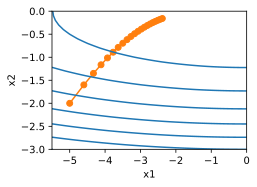

In [2]:
def adagrad_2d(x1, x2, s1, s2):
    eps = 1e-6
    g1, g2 = 0.2 * x1, 4 * x2
    s1 += g1 ** 2
    s2 += g2 ** 2
    x1 -= eta / math.sqrt(s1 + eps) * g1
    x2 -= eta / math.sqrt(s2 + eps) * g2
    return x1, x2, s1, s2

def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2

eta = 0.4
d2l.show_trace_2d(f_2d, d2l.train_2d(adagrad_2d))

As we increase the learning rate to $2$ we see much better behavior. This already indicates that the decrease in learning rate might be rather aggressive, even in the noise-free case and we need to ensure that parameters converge appropriately.


epoch 20, x1: -0.002295, x2: -0.000000


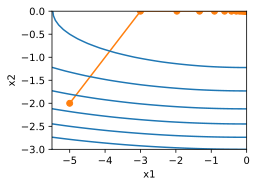

In [3]:
eta = 2
d2l.show_trace_2d(f_2d, d2l.train_2d(adagrad_2d))

## Implementation from Scratch

Just like the momentum method, Adagrad needs to maintain a state variable of the same shape as the parameters.


In [4]:
def init_adagrad_states(feature_dim):
    s_w = np.zeros((feature_dim, 1))
    s_b = np.zeros(1)
    return (s_w, s_b)

def adagrad(params, states, hyperparams):
    eps = 1e-6
    for p, s in zip(params, states):
        s[:] += np.square(p.grad)
        p[:] -= hyperparams['lr'] * p.grad / np.sqrt(s + eps)

Compared to the experiment in :numref:`sec_minibatch_sgd` we use a
larger learning rate to train the model.


loss: 0.243, 1.073 sec/epoch


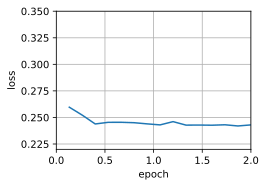

In [5]:
data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
d2l.train_ch11(adagrad, init_adagrad_states(feature_dim),
               {'lr': 0.1}, data_iter, feature_dim);

## Concise Implementation

Using the `Trainer` instance of the algorithm `adagrad`, we can invoke the Adagrad algorithm in Gluon.


loss: 0.242, 1.009 sec/epoch


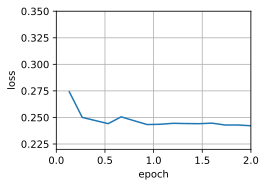

In [6]:
d2l.train_concise_ch11('adagrad', {'learning_rate': 0.1}, data_iter)

## Summary

* Adagrad decreases the learning rate dynamically on a per-coordinate basis.
* It uses the magnitude of the gradient as a means of adjusting how quickly progress is achieved - coordinates with large gradients are compensated with a smaller learning rate.
* Computing the exact second derivative is typically infeasible in deep learning problems due to memory and computational constraints. The gradient can be a useful proxy.
* If the optimization problem has a rather uneven structure Adagrad can help mitigate the distortion.
* Adagrad is particularly effective for sparse features where the learning rate needs to decrease more slowly for infrequently occurring terms.
* On deep learning problems Adagrad can sometimes be too aggressive in reducing learning rates. We will discuss strategies for mitigating this in the context of :numref:`sec_adam`.

## Exercises

1. Prove that for an orthogonal matrix $\mathbf{U}$ and a vector $\mathbf{c}$ the following holds: $\|\mathbf{c} - \mathbf{\delta}\|_2 = \|\mathbf{U} \mathbf{c} - \mathbf{U} \mathbf{\delta}\|_2$. Why does this mean that the magnitude of perturbations does not change after an orthogonal change of variables?
1. Try out Adagrad for $f(\mathbf{x}) = 0.1 x_1^2 + 2 x_2^2$ and also for the objective function was rotated by 45 degrees, i.e., $f(\mathbf{x}) = 0.1 (x_1 + x_2)^2 + 2 (x_1 - x_2)^2$. Does it behave differently?
1. Prove [Gerschgorin's circle theorem](https://en.wikipedia.org/wiki/Gershgorin_circle_theorem) which states that eigenvalues $\lambda_i$ of a matrix $\mathbf{M}$ satisfy $|\lambda_i - \mathbf{M}_{jj}| \leq \sum_{k \neq j} |\mathbf{M}_{jk}|$ for at least one choice of $j$.
1. What does Gerschgorin's theorem tell us about the eigenvalues of the diagonally preconditioned matrix $\textrm{diag}^{-\frac{1}{2}}(\mathbf{M}) \mathbf{M} \textrm{diag}^{-\frac{1}{2}}(\mathbf{M})$?
1. Try out Adagrad for a proper deep network, such as :numref:`sec_lenet` when applied to Fashion-MNIST.
1. How would you need to modify Adagrad to achieve a less aggressive decay in learning rate?


[Discussions](https://discuss.d2l.ai/t/355)
